In [1]:
import pandas as pd
import yfinance as yf

In [2]:
df = yf.download('TTM').reset_index()

[*********************100%***********************]  1 of 1 completed


In [3]:
#df=pd.read_csv('AAPL.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-09-27,9.15,9.28,9.05,9.15,7.971042,379700
1,2004-09-28,8.85,8.85,8.65,8.76,7.631292,332700
2,2004-09-29,8.76,8.78,8.66,8.75,7.622581,119800
3,2004-09-30,8.89,8.97,8.89,8.97,7.814236,166400
4,2004-10-01,9.14,9.34,9.12,9.25,8.058157,266600


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4405,2022-03-25,28.330000,28.410000,28.000000,28.400000,28.400000,505700
4406,2022-03-28,28.440001,28.700001,28.270000,28.540001,28.540001,329900
4407,2022-03-29,28.990000,29.590000,28.990000,29.150000,29.150000,1183500
4408,2022-03-30,28.690001,28.780001,28.030001,28.250000,28.250000,868000
4409,2022-03-31,28.170000,28.340000,27.950001,27.950001,27.950001,1051700


In [6]:
df1=df.reset_index()['Close']

In [7]:
df1

0        9.150000
1        8.760000
2        8.750000
3        8.970000
4        9.250000
          ...    
4405    28.400000
4406    28.540001
4407    29.150000
4408    28.250000
4409    27.950001
Name: Close, Length: 4410, dtype: float64

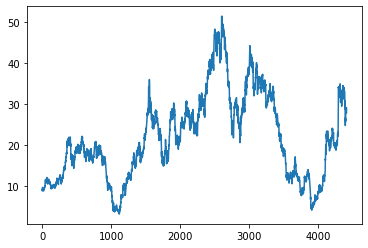

In [8]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [9]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [10]:
import numpy as np

In [11]:
df1

0        9.150000
1        8.760000
2        8.750000
3        8.970000
4        9.250000
          ...    
4405    28.400000
4406    28.540001
4407    29.150000
4408    28.250000
4409    27.950001
Name: Close, Length: 4410, dtype: float64

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
print(len(df1))

4410


In [14]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(2866, 1544)

In [16]:
train_data

array([[0.12435339],
       [0.11628388],
       [0.11607697],
       ...,
       [0.39871714],
       [0.36043863],
       [0.38071592]])

In [17]:
test_data

array([[0.39292362],
       [0.41009722],
       [0.41278708],
       ...,
       [0.53817502],
       [0.51955306],
       [0.51334575]])

In [26]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        #print(a) ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [27]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
print(X_train.shape), print(y_train.shape)

(2765, 100)
(2765,)


(None, None)

In [29]:
print(X_test.shape), print(ytest.shape)

(1443, 100)
(1443,)


(None, None)

In [32]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [33]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [34]:
X_train.shape[1]

100

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


2022-04-01 09:18:58.549674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-01 09:18:58.549708: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-01 09:18:58.549729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PrincePat3l): /proc/driver/nvidia/version does not exist
2022-04-01 09:18:58.550011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
44/44 [==============================] - 19s 283ms/step - loss: 0.0235 - val_loss: 0.0024
Epoch 2/10
44/44 [==============================] - 11s 249ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/10
44/44 [==============================] - 9s 209ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 4/10
44/44 [==============================] - 11s 248ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/10
44/44 [==============================] - 10s 233ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/10
44/44 [==============================] - 10s 219ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 7/10
44/44 [==============================] - 11s 250ms/step - loss: 9.4834e-04 - val_loss: 0.0011
Epoch 8/10
44/44 [==============================] - 10s 226ms/step - loss: 9.6555e-04 - val_loss: 9.8927e-04
Epoch 9/10
44/44 [==============================] - 10s 237ms/step - loss: 8.8712e-04 - val_loss: 0.0012
Epoch 10/10
44/44 [==============================] - 10s 231ms/step - loss: 

In [40]:
import tensorflow as tf

In [41]:
tf.__version__

'2.8.0'

In [54]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [55]:
X_train.shape

(2765, 100, 1)

In [56]:
X_test.shape

(1443, 100, 1)

In [57]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [58]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

23.686710055230954

In [59]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

23.87209544965775

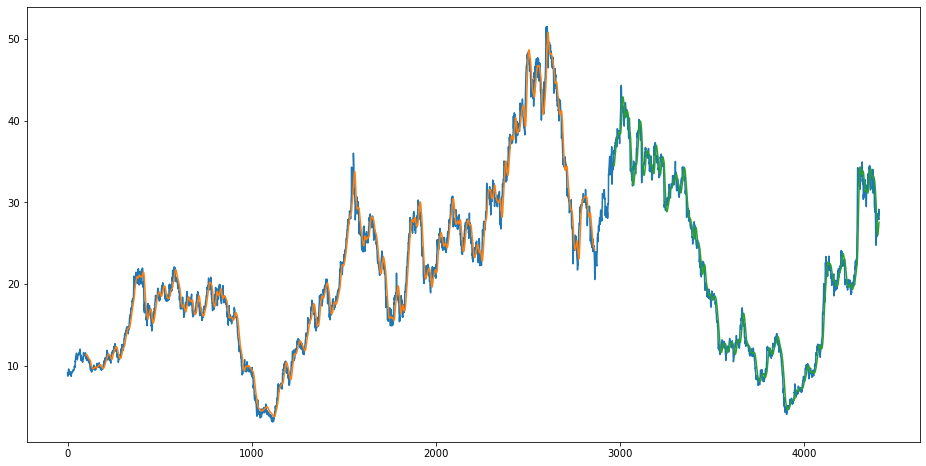

In [60]:
### Plotting 
# shift train predictions for plotting
plt.figure(figsize=(16,8))
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [61]:
len(test_data)

1544

In [90]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [91]:
temp_input=list(x_input)
#print(temp_input)
#print("111111111111111111111------------")
temp_input=temp_input[0].tolist()
#print(temp_input)

In [92]:
#temp_input

In [93]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.5154253]
101
1 day input [0.63045727 0.62735357 0.63004344 0.62962961 0.62962961 0.65218289
 0.65797637 0.62073244 0.6271467  0.60211051 0.61452513 0.61535279
 0.56321125 0.57562587 0.56693565 0.58224705 0.59652387 0.58576454
 0.5723153  0.59404096 0.60976619 0.60004135 0.61266293 0.59611008
 0.59073039 0.60024831 0.5894889  0.56217668 0.54479616 0.56362505
 0.58679907 0.58079864 0.59259259 0.5913511  0.58783361 0.58328159
 0.59900682 0.62776741 0.60190355 0.59611008 0.614732   0.61535279
 0.6308711  0.64121664 0.64514792 0.63852678 0.64887232 0.63397471
 0.64473409 0.63914749 0.60997306 0.58700599 0.5950755  0.59197184
 0.61162839 0.61307676 0.63356088 0.62611216 0.63149181 0.62011173
 0.61990477 0.61369746 0.61762882 0.63914749 0.6252845  0.60128285
 0.57872956 0.62197393 0.61887023 0.61721499 0.6110076  0.58783361
 0.57707428 0.54252017 0.5723153  0.56176288 0.53093314 0.55348642
 0.51603557 0.47982618 0.44713427 0.45023793 0.4862404  0.47548107
 0.47713636 0.46823919 0.50610386 

9 day output [[0.52863467]]
10 day input [0.60211051 0.61452513 0.61535279 0.56321125 0.57562587 0.56693565
 0.58224705 0.59652387 0.58576454 0.5723153  0.59404096 0.60976619
 0.60004135 0.61266293 0.59611008 0.59073039 0.60024831 0.5894889
 0.56217668 0.54479616 0.56362505 0.58679907 0.58079864 0.59259259
 0.5913511  0.58783361 0.58328159 0.59900682 0.62776741 0.60190355
 0.59611008 0.614732   0.61535279 0.6308711  0.64121664 0.64514792
 0.63852678 0.64887232 0.63397471 0.64473409 0.63914749 0.60997306
 0.58700599 0.5950755  0.59197184 0.61162839 0.61307676 0.63356088
 0.62611216 0.63149181 0.62011173 0.61990477 0.61369746 0.61762882
 0.63914749 0.6252845  0.60128285 0.57872956 0.62197393 0.61887023
 0.61721499 0.6110076  0.58783361 0.57707428 0.54252017 0.5723153
 0.56176288 0.53093314 0.55348642 0.51603557 0.47982618 0.44713427
 0.45023793 0.4862404  0.47548107 0.47713636 0.46823919 0.50610386
 0.52389817 0.51603557 0.52658803 0.51065589 0.52700186 0.51748394
 0.52638111 0.52265671 

18 day output [[0.5317529]]
19 day input [0.5723153  0.59404096 0.60976619 0.60004135 0.61266293 0.59611008
 0.59073039 0.60024831 0.5894889  0.56217668 0.54479616 0.56362505
 0.58679907 0.58079864 0.59259259 0.5913511  0.58783361 0.58328159
 0.59900682 0.62776741 0.60190355 0.59611008 0.614732   0.61535279
 0.6308711  0.64121664 0.64514792 0.63852678 0.64887232 0.63397471
 0.64473409 0.63914749 0.60997306 0.58700599 0.5950755  0.59197184
 0.61162839 0.61307676 0.63356088 0.62611216 0.63149181 0.62011173
 0.61990477 0.61369746 0.61762882 0.63914749 0.6252845  0.60128285
 0.57872956 0.62197393 0.61887023 0.61721499 0.6110076  0.58783361
 0.57707428 0.54252017 0.5723153  0.56176288 0.53093314 0.55348642
 0.51603557 0.47982618 0.44713427 0.45023793 0.4862404  0.47548107
 0.47713636 0.46823919 0.50610386 0.52389817 0.51603557 0.52658803
 0.51065589 0.52700186 0.51748394 0.52638111 0.52265671 0.52555349
 0.53817502 0.51955306 0.51334575 0.51542532 0.51915669 0.52197981
 0.52403432 0.5254910

26 day output [[0.53396446]]
27 day input [0.5894889  0.56217668 0.54479616 0.56362505 0.58679907 0.58079864
 0.59259259 0.5913511  0.58783361 0.58328159 0.59900682 0.62776741
 0.60190355 0.59611008 0.614732   0.61535279 0.6308711  0.64121664
 0.64514792 0.63852678 0.64887232 0.63397471 0.64473409 0.63914749
 0.60997306 0.58700599 0.5950755  0.59197184 0.61162839 0.61307676
 0.63356088 0.62611216 0.63149181 0.62011173 0.61990477 0.61369746
 0.61762882 0.63914749 0.6252845  0.60128285 0.57872956 0.62197393
 0.61887023 0.61721499 0.6110076  0.58783361 0.57707428 0.54252017
 0.5723153  0.56176288 0.53093314 0.55348642 0.51603557 0.47982618
 0.44713427 0.45023793 0.4862404  0.47548107 0.47713636 0.46823919
 0.50610386 0.52389817 0.51603557 0.52658803 0.51065589 0.52700186
 0.51748394 0.52638111 0.52265671 0.52555349 0.53817502 0.51955306
 0.51334575 0.51542532 0.51915669 0.52197981 0.52403432 0.52549106
 0.52651566 0.52724868 0.52779913 0.52824414 0.52863467 0.529001
 0.52935863 0.52971429

In [94]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [95]:
import matplotlib.pyplot as plt

In [96]:
len(df1)

4410

30


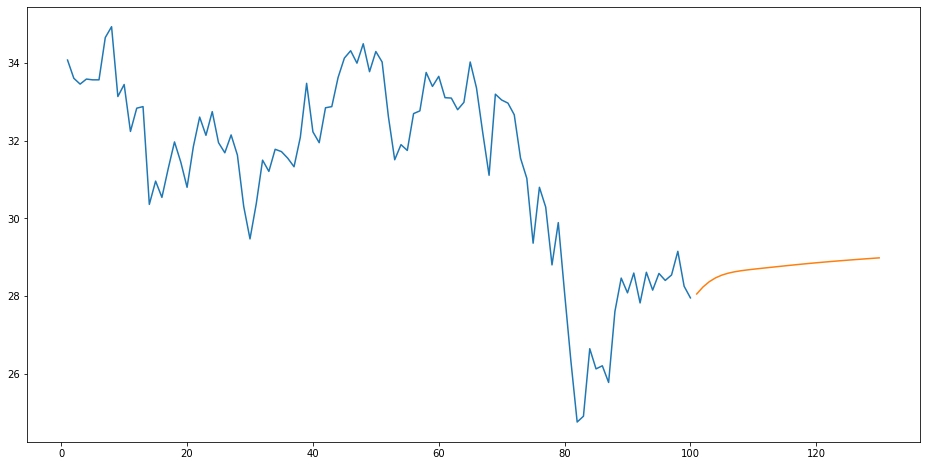

In [109]:
plt.figure(figsize=(16,8))
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
print(len(lst_output))

4440


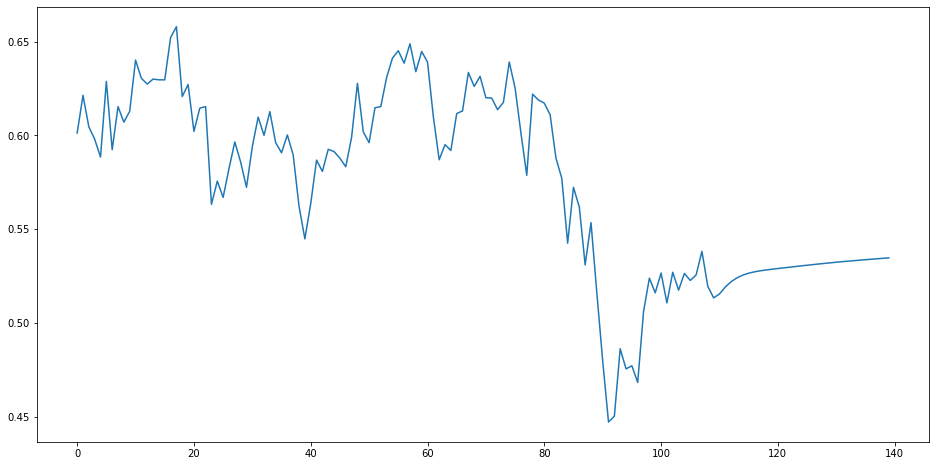

In [124]:
plt.figure(figsize=(16,8))
df3=df1.tolist()
df3.extend(lst_output)
print(len(df3))
plt.plot(df3[4300:])
#print(df3[:len(df1)])
#print("--------------------------------------------------")
#print(df3[len(df1):])
#plt.plot(lst_output, color="green")
#plt.plot(df['Date'], df3[:len(df1)], color="blue")
#plt.plot(df3[len(df1):], color="red")

In [125]:
df3=scaler.inverse_transform(df3).tolist()

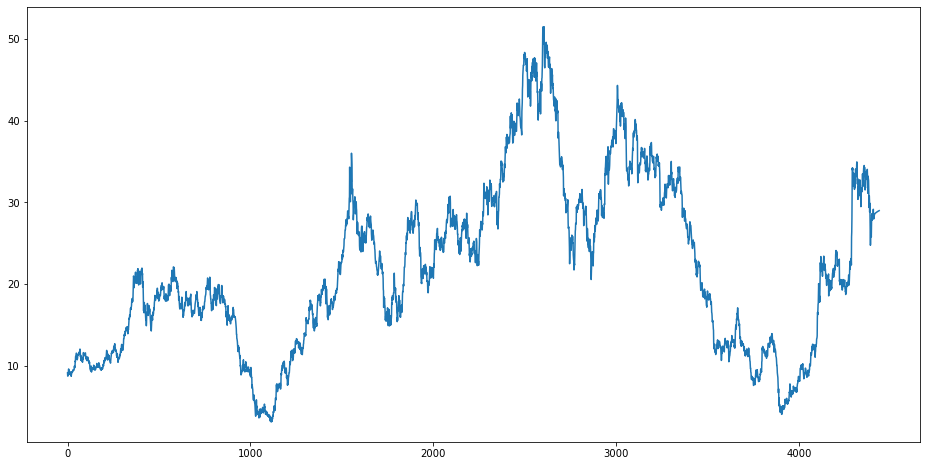

In [127]:
plt.figure(figsize=(16,8))
plt.plot(df3)